# Time series modeling: Linear Regression and Decision Trees

Notebook to add time series variables to models using pyspark. Based on [this blog post](https://medium.com/analytics-vidhya/time-series-forecasting-using-spark-ml-part-2-31506514c643)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, LongType

import statsmodels.tsa.stattools as ts

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# start session
spark = SparkSession.builder.master("local[5]").appName("groupbyagg").getOrCreate()

# Data

In [4]:
data = spark.read.csv('hdfs://cluster-7b78-m/user/dataproc/Sunspots.csv',inferSchema=True,header=True)

In [5]:
data = data.withColumnRenamed('Monthly Mean Total Sunspot Number', 'sunspots')
data = data.select(to_date(col("date"),"yyyy-mm-dd").alias("date"), 'sunspots')
data.show(1)

+----------+--------+
|      date|sunspots|
+----------+--------+
|1749-01-31|    96.7|
+----------+--------+
only showing top 1 row



In [6]:
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- sunspots: double (nullable = true)



# Create Variables

Before running the next code, set the following variables:
* n_lags: the number of previous months to lag with
* data_lag: a new dataframe to put lagged variables in
* features: a list of the features created (for use in vectorassembler later)
* forecast_months: number of time-steps to forecast (for example, we could say 10 and get the predicted average sunspots for the next 10 months)

In [7]:
n_lags = 5
data_lag = data.select('*')
features = ['sunspots']
forecast_months = 10

## Create lags

Create the time-lagged mean sunspot values

In [8]:
# add col to partition by
data_lag = data_lag.withColumn("Series",lit('Univariate'))

# set up window
lag_window = Window.orderBy("Series")

for i in range(n_lags):
    str_lag = 'sunspots'+'_lag_'+str(i+1)
    data_lag = data_lag.withColumn(str_lag,
                                   lag(data_lag['sunspots'], i+1).over(lag_window))
    features.append(str_lag)
    
data_lag = data_lag.drop('Series')    
data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|
+----------+--------+--------------+--------------+--------------+--------------+--------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|
|1749-02-28|   104.3|          96.7|          null|          null|          null|          null|
|1749-03-31|   116.7|         104.3|          96.7|          null|          null|          null|
|1749-04-30|    92.8|         116.7|         104.3|          96.7|          null|          null|
|1749-05-31|   141.7|          92.8|         116.7|         104.3|          96.7|          null|
+----------+--------+--------------+--------------+--------------+--------------+--------------+
only showing top 5 rows



## Moving average over lag window

In [9]:
mavg_window = Window.rowsBetween(-n_lags, 0)
str_mov_avg = 'sunspots'+'_' + str(n_lags)+'_moving_avg'
data_lag = data_lag.withColumn(str_mov_avg, avg(data_lag['sunspots']).over(mavg_window))
features.append(str_mov_avg)
data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|sunspots_5_moving_avg|
+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|                 96.7|
|1749-02-28|   104.3|          96.7|          null|          null|          null|          null|                100.5|
|1749-03-31|   116.7|         104.3|          96.7|          null|          null|          null|   105.89999999999999|
|1749-04-30|    92.8|         116.7|         104.3|          96.7|          null|          null|              102.625|
|1749-05-31|   141.7|          92.8|         116.7|         104.3|          96.7|          null|   110.44000000000001|
+----------+--------+--------------+------------

## Time Series Trends

How do sunspots change from one month to the next? Use this sign variable to find out

In [10]:
# if current sunspots > time-lagged sunspots then sign = +1.0
# if current sunspots < time-lagged sunspots then sign = -1.0
data_lag = data_lag.withColumn("Series",lit('Univariate'))       
trend_window = Window.orderBy("Series")
for i in range(n_lags):
    str_sign = 'sunspots' +'_lag_'+str(i+1)+'_sign'
    data_lag = data_lag.withColumn(str_sign,\
                        signum((data_lag['sunspots'] - lag(data_lag['sunspots'],i+1).over(trend_window))))
    features.append(str_sign)

data_lag = data_lag.drop("Series")

data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|sunspots_5_moving_avg|sunspots_lag_1_sign|sunspots_lag_2_sign|sunspots_lag_3_sign|sunspots_lag_4_sign|sunspots_lag_5_sign|
+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|                 96.7|               null|               null|               null|               null|               null|
|1749-02-28|   104.3|          96.7|          null|          null|          null|          null|                100.5|      

## Put all above data manipulations into one function

In [11]:
def create_ts_vars(data, n_lags, features):

  ## LAG VARS ######################################################################
  # add col to partition by
  data = data.withColumn("Series",lit('Univariate'))

  # set up window
  lag_window = Window.orderBy("Series")

  for i in range(n_lags):
      str_lag = 'sunspots'+'_lag_'+str(i+1)
      data = data.withColumn(str_lag, lag(data['sunspots'], i+1).over(lag_window))
      features.append(str_lag)
      
  data = data.drop('Series')   

  ## MOVING AVG VAR ##############################################################
  mavg_window = Window.rowsBetween(-n_lags, 0)
  str_mov_avg = 'sunspots'+'_' + str(n_lags)+'_moving_avg'
  data = data.withColumn(str_mov_avg, avg(data['sunspots']).over(mavg_window))
  features.append(str_mov_avg)

  ## TREND VAR ###################################################################
  # if current sunspots > time-lagged sunspots then sign = +1.0
  # if current sunspots < time-lagged sunspots then sign = -1.0
  data = data.withColumn("Series",lit('Univariate'))       
  trend_window = Window.orderBy("Series")
  for i in range(n_lags):
      str_sign = 'sunspots' +'_lag_'+str(i+1)+'_sign'
      data = data.withColumn(str_sign,\
                          signum((data['sunspots'] - lag(data['sunspots'],i+1).over(trend_window))))
      features.append(str_sign)
      
  data = data.drop("Series")
  
  return(data)

## Train/Test Split

In [12]:
def split_time_series(data, train_ratio=0.7):
     
    # split data into train and test but maintain time-order
    newSchema  = StructType(data.schema.fields + \
                [StructField('Row Number', LongType(), False)])
    new_rdd = data.rdd.zipWithIndex().map(lambda x: list(x[0]) + [x[1]])

    # create new df with row number
    new_df = spark.createDataFrame(new_rdd, newSchema)
    total_rows = new_df.count()
    splitFraction  =int(total_rows*train_ratio)

    df_train = new_df.where(new_df['Row Number'] >= 0)\
                   .where(new_df['Row Number'] <= splitFraction)
    df_test = new_df.where(new_df['Row Number'] > splitFraction)
    
    return df_train, df_test

## Set up data for modeling

In [13]:
def data_for_modeling(data, forecast_months):
  # create label 
  lead_window = Window.rowsBetween(0,forecast_months)   
  data = data.withColumn("label", last(data['sunspots']).over(lead_window))
  
  # vector assembler
  data = data.dropna()
  assembler = VectorAssembler().setInputCols(features).setOutputCol("features")
  data_transformed = assembler.transform(data)

  return(data_transformed)

# Helper Functions

## Check that distribution is stationary 

In [14]:
def CheckStationarity(timeSeriesCol):
    
    # this function works with Pandas dataframe only not with spark dataframes
    # this performs Augmented Dickey-Fuller's test
    
    test_result = ts.adfuller(timeSeriesCol.values)
    print('ADF Statistic : %f \n' %test_result[0])
    print('p-value : %f \n' %test_result[1])
    print('Critical values are: \n')
    print(test_result[4])

## Prediction

In [15]:
def Predict(I, df1, df2, timeSeriesCol, predictionCol, joinCol):
    
    # converts differenced predictions to raw predictions
    dZCol = 'DeltaZ'+str(i) 
    f_strCol = 'forecast_'+str(i)+'day'
    df = df1.join(df2, [joinCol], how='inner').orderBy(asc('Date'))
    df = df.withColumnRenamed(predictionCol, dZCol)
    df = df.withColumn(f_strCol, col(dZCol)+col(timeSeriesCol))

    return df

## Save results for comparison

# Data for Modeling

1. Run create_ts_vars using desired variables

In [16]:
n_lags = 12*5
data_lag = data.select('*')
features = ['sunspots']
forecast_months = 10

In [35]:
data_lag = create_ts_vars(data_lag, n_lags, features)
#data_lag.show(1)

In [18]:
len(data_lag.columns)-1

122

2. Set up data for modeling (set up label, [features])

In [19]:
data_transformed = data_for_modeling(data_lag, forecast_months)

3. Train-test split

In [20]:
train, test = split_time_series(data_transformed, 0.7)

In [21]:
print(train.count())
print(test.count())

2244
961


Now the data is ready for modeling! 

# Linear Regression

In [22]:
def lr_fxn(train, test):
  # init model
  lr = LinearRegression(featuresCol = "features", labelCol="label", \
                                maxIter = 100, regParam = 0.4, \
                                elasticNetParam = 0.1)
  
  # fit model 
  model = lr.fit(train)
  pred_train = model.transform(train)
  pred_test = model.transform(test)
  

  # calc rmse
  evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName ="rmse")
  RMSE_train = evaluator.evaluate(pred_train)
  RMSE_test= evaluator.evaluate(pred_test)

  return train, test, pred_train, pred_test, RMSE_train, RMSE_test

In [23]:
lr_train, lr_test, lr_pred_train, lr_pred_test, lr_RMSE_train, lr_RMSE_test = lr_fxn(train, test)

lr_pred_train.select(['date', 'label','prediction']).show(5)

+----------+-----+-------------------+
|      date|label|         prediction|
+----------+-----+-------------------+
|1754-01-31| 22.0| 22.606026699335033|
|1754-02-28|  7.0| 15.872801337446775|
|1754-03-31| 17.0|  5.662900255015561|
|1754-04-30| 18.7|-0.1879679500404059|
|1754-05-31| 11.3|  4.620182823792053|
+----------+-----+-------------------+
only showing top 5 rows



In [24]:
lr_RMSE_test

36.79656508726615

In [25]:
lr_RMSE_train

33.76463311258374

Graph

/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


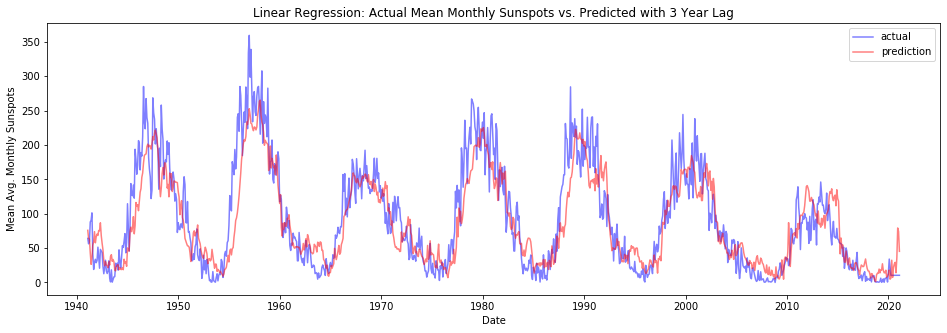

In [26]:
# label & prediction
lr_pred_test_df = lr_pred_test.select(['date', 'label','prediction']).toPandas()

fig = plt.figure(figsize=(16,5))
plt.plot(lr_pred_test_df['date'], lr_pred_test_df['label'], color='blue', label='actual', alpha=0.5)
plt.plot(lr_pred_test_df['date'], lr_pred_test_df['prediction'], color='red', label='prediction', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Mean Avg. Monthly Sunspots')
plt.title('Linear Regression: Actual Mean Monthly Sunspots vs. Predicted with 3 Year Lag')
plt.legend(loc="upper right")

plt.show()

# Decision Tree

In [27]:
def dt_fxn(train, test, max_depth=5):
  # init
  dt = DecisionTreeRegressor(featuresCol = "features", labelCol = "label", maxDepth = max_depth)

  # fit model & get preds
  model = dt.fit(train)
  pred_train = model.transform(train)
  pred_test = model.transform(test)
  
  # calc rmse
  evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName ="rmse")
  RMSE_train = evaluator.evaluate(pred_train)
  RMSE_test= evaluator.evaluate(pred_test)

  return train, test, pred_train, pred_test, RMSE_train, RMSE_test

In [28]:
dt_train, dt_test, dt_pred_train, dt_pred_test, dt_RMSE_train, dt_RMSE_test = dt_fxn(train, test, max_depth=10)

dt_pred_train.select(['date', 'label','prediction']).show(5)

+----------+-----+------------------+
|      date|label|        prediction|
+----------+-----+------------------+
|1754-01-31| 22.0|13.243333333333336|
|1754-02-28|  7.0|18.022522522522525|
|1754-03-31| 17.0|18.022522522522525|
|1754-04-30| 18.7|13.243333333333336|
|1754-05-31| 11.3|13.243333333333336|
+----------+-----+------------------+
only showing top 5 rows



In [29]:
dt_RMSE_test

45.475663194110304

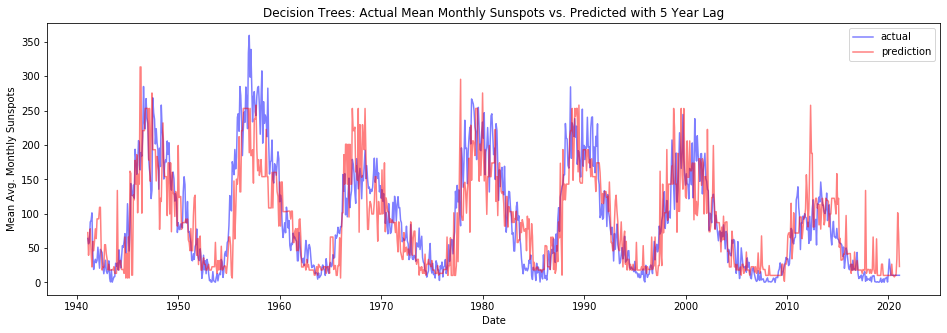

In [30]:
# label & prediction
dt_pred_test_df = dt_pred_test.select(['date', 'label','prediction']).toPandas()

fig = plt.figure(figsize=(16,5))
plt.plot(dt_pred_test_df['date'], dt_pred_test_df['label'], color='blue', label='actual', alpha=0.5)
plt.plot(dt_pred_test_df['date'], dt_pred_test_df['prediction'], color='red', label='prediction', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Mean Avg. Monthly Sunspots')
plt.title('Decision Trees: Actual Mean Monthly Sunspots vs. Predicted with 5 Year Lag')
plt.legend(loc="upper right")

plt.show()

# Forecast for Best Model

## Time Differencing

Function for first-order differencing -- creates stationary

In [31]:
def first_order_diff(data, input_col, output_col):
    # performs first-order differencing
    lag1_window = window.Window.rowsBetween(-1, 0)
    data = data.withColumn(output_col, data[input_col] -  first(data[input_col]).over(lag1_window))
    return data

# Stop session

In [36]:
spark.stop()